In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arch
import scipy as sp  
import scipy.stats as scs

from sklearn.neighbors import KernelDensity
from arch import arch_model

In [30]:
btc      = pd.read_csv('BTCUSDT.csv')
btc      = btc[(btc['Date'] >= '2018-03-31') & (btc['Date'] < '2019-10-01')]
rt       = btc[(btc['Date'] >= '2019-03-31') & (btc['Date'] < '2019-10-01')]

btc.Date = pd.to_datetime(btc.Date)
btc.set_index('Date',inplace=True)


In [31]:
btc['returns']     = btc['Adj.Close'].pct_change()
btc['log_returns'] = np.log(btc['Adj.Close']).diff()
returnseries       = np.log(rt['Adj.Close']).diff()
btc = btc.dropna()

In [32]:
interval = 365
windows = [btc['log_returns'][slice(i,i+interval)]for i in range(len(btc)-interval)]

In [33]:
rows = []
tmp       = []
for window in windows:
    garch = arch.arch_model(window - window.mean(), mean="Zero", rescale=False)
    res   = garch.fit(disp="off")
    #print(res.summary())
    alpha0=res.params[0]
    alpha1=res.params[1]
    beta=res.params[2]
    volest = alpha0 + (alpha1 * window[-1]**2 + beta * res.conditional_volatility[-1]**2)
    forecast_date = window.index[-1]
    rows.append([forecast_date, np.sqrt(volest)])
    
df = pd.DataFrame(rows, columns=['date', 'vol']).set_index('date')
garchvol = df['vol'].to_list()

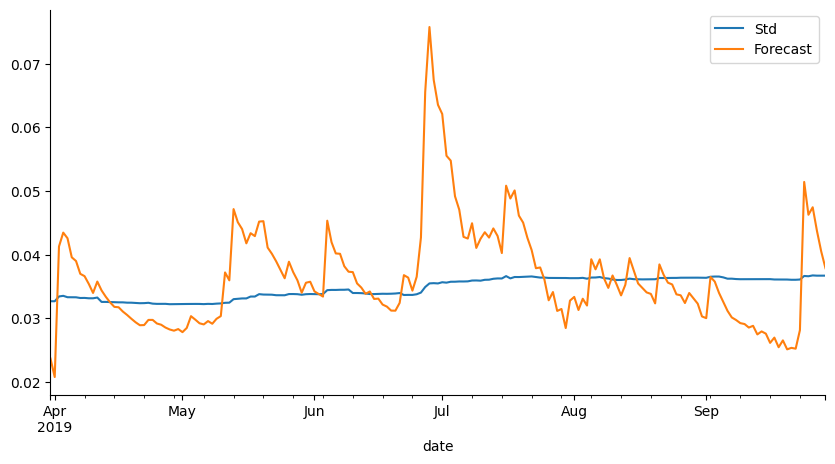

In [34]:
df['rollingstd'] = np.std(windows, axis=1)

fig, ax = plt.subplots(figsize=(10, 5))
df['rollingstd'].plot(ax=ax, label="Std")
df['vol'].plot(ax=ax, label="Forecast")

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.legend()


fig.savefig('volestimate.png',transparent=True)

In [35]:
vol = pd.DataFrame({'volatility forecast':garchvol})

vol_dates = rt['Date']

vol = vol.join(vol_dates)
vol

,volatility forecast,Date
0,0.023644,NaN
1,0.020737,NaN
2,0.041273,NaN
3,0.043453,NaN
4,0.042567,NaN
...,...,...
178,0.046262,NaN
179,0.047442,NaN
180,0.043722,NaN
181,0.040491,NaN


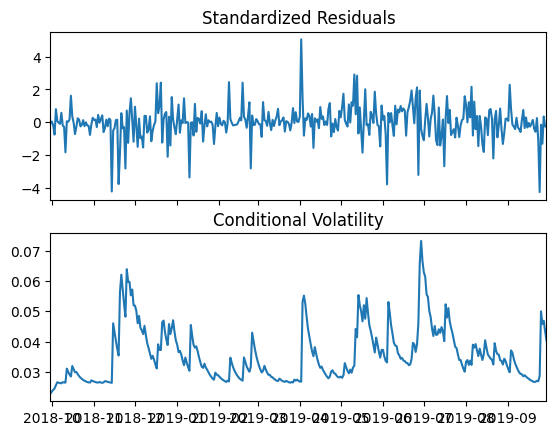

In [36]:
fig = res.plot()

Text(0.5, 0, 'days')

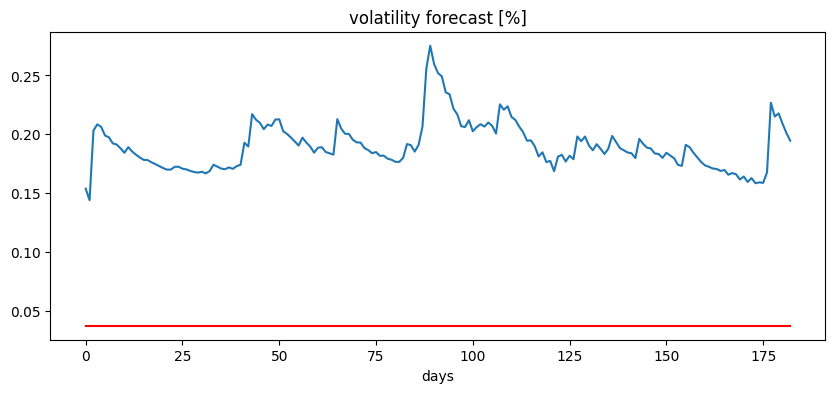

In [37]:
unconditional_vol=np.sqrt(res.params[0]/(1-res.params[1]-res.params[2]))*np.ones(len(garchvol))
plt.figure(figsize=(10, 4))
plt.plot(np.sqrt(garchvol))

plt.plot(unconditional_vol, 'r')
plt.title('volatility forecast [%]')
plt.xlabel('days')

In [11]:
returnseries = list(returnseries.dropna())
returnseries

[0.010011200340887427,
 0.13597890237839216,
 0.07907130655778083,
 -0.044657407966633755,
 0.012868790790273366,
 0.0072087024357081475,
 0.024058333325150727,
 0.01690746602468174,
 -0.009902499393994901,
 0.018958939294943633,
 -0.05448102294249679,
 0.009675700842784352,
 0.0017837681867742816,
 0.006442568352987621,
 -0.011270043467414226,
 0.029489176818948692,
 0.0069137142708086685,
 0.011256438610470099,
 -0.004546460656937867,
 0.0017270849031518765,
 -0.004385420000751594,
 0.02310876810401652,
 0.033751289865669776,
 -0.02566160885206692,
 -0.0020561966137346843,
 -0.01738513274299791,
 0.006218526260960644,
 -0.00809940752131233,
 -0.014039169206442992,
 0.019872531658537085,
 0.008852689679864412,
 0.025559514720253418,
 0.05047691512042363,
 0.005077806671456742,
 -0.002695990187913111,
 -0.007532435054532272,
 0.03259162457719533,
 3.0261815139098758e-05,
 0.036694581498053935,
 0.03211468756765434,
 0.09387272222864596,
 0.02181489468588893,
 0.11787001508456108,
 -0.0

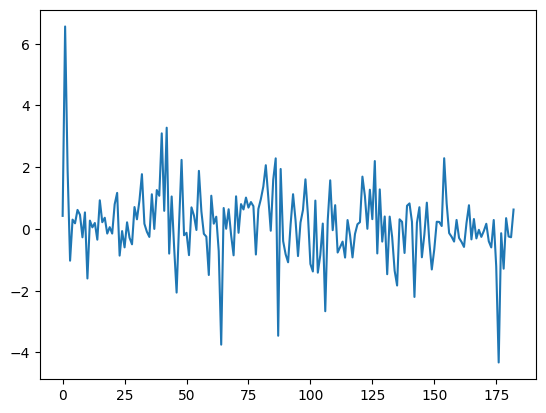

In [12]:
degarched = [x/y for x,y in zip(returnseries,garchvol)]
plt.plot(degarched)

In [13]:
from scipy import stats
kernel = stats.gaussian_kde(degarched)
kernel

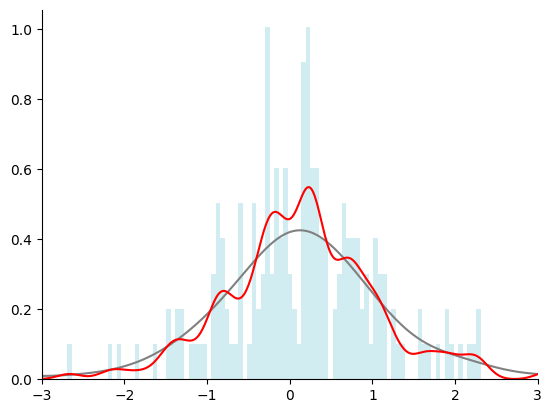

In [14]:
import scipy.stats as stats
x1 = np.array(degarched)
kde = stats.gaussian_kde(x1)
xs = np.linspace(-3, 3, num=500)
y1 = kde(xs)
kde.set_bandwidth(bw_method='silverman')
y2 = kde(xs)
kde.set_bandwidth(bw_method=kde.factor / 3.)
y3 = kde(xs)

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.set_xlim(-3, 3)
#ax.plot(x1, np.full(x1.shape, 1 / (4. * x1.size)), 'bo',
#        label='Data points (rescaled)')
#ax.plot(xs, y1, label='Scott (default)')
ax.hist(np.array(degarched), bins=200, density=True, color = '#d1edf2')
ax.plot(xs, y2, color='grey')
ax.plot(xs, y3, color='red')


# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.show()

fig.savefig('silverman_kde',transparent=True)

# Non-resampled

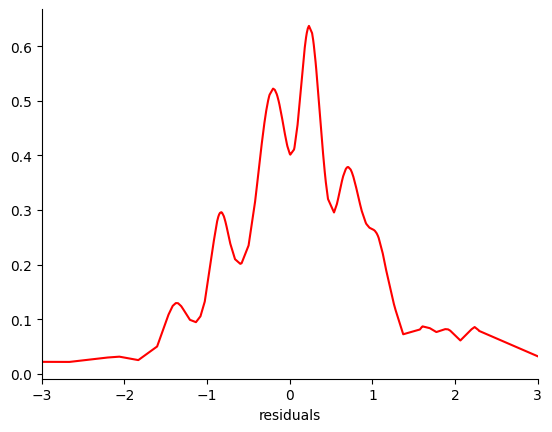

In [15]:
kde_non_resampled = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(np.array(degarched).reshape(-1, 1))
log_dens = kde_non_resampled.score_samples(np.array(degarched).reshape(-1, 1))
density = np.exp(log_dens)
fig, ax = plt.subplots()
ax.set_xlim(-3, 3)
#ax.hist(np.array(degarched), bins=200, density=True, color = "black") #d1edf2
samples = kde_non_resampled.sample(20000).T[0]
#ax.hist(samples, bins=200, density=True, alpha=0.7, color="darkgrey") 
df = pd.DataFrame(np.array([np.array(degarched).reshape(-1, 1).T[0], density]).T, columns=['x', 'density']).set_index('x').sort_index()
df['density'].plot(ax=ax, c='r')
ax.set_xlabel("residuals")

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')


fig.savefig('hd_kde.png',transparent=True)

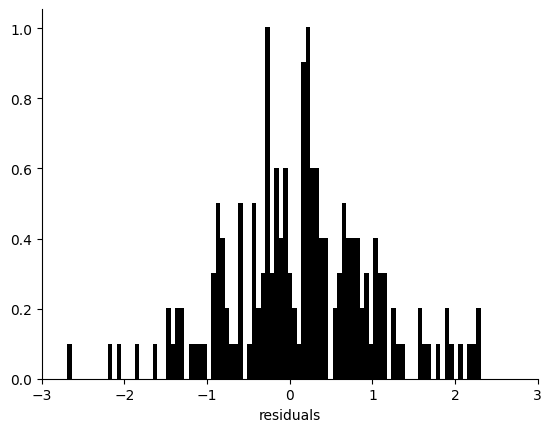

In [16]:
fig, ax = plt.subplots()
ax.set_xlim(-3, 3)
ax.hist(np.array(degarched), bins=200, density=True, color = "black") #d1edf2
ax.set_xlabel("residuals")

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')


fig.savefig('hist_resid.png',transparent=True)

# Multiply volatilty

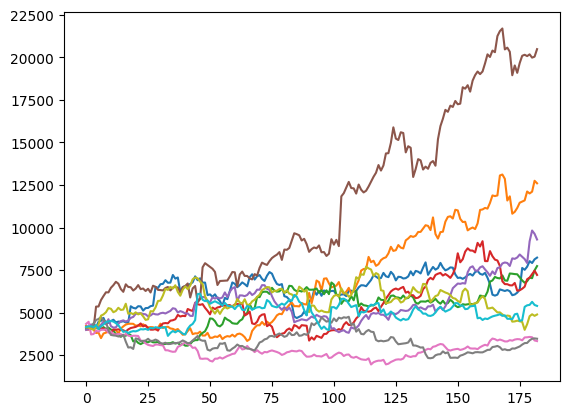

In [17]:
def path():
    spot = rt["Adj.Close"].iloc[0]
    return spot * np.exp(np.cumsum(garchvol * kde_non_resampled.sample(len(garchvol)).T[0]))

paths = np.array([path() for _ in range(10)])
plt.plot(paths.T)
plt.savefig('scenarios_kde.png',transparent=True)

In [18]:
s = np.array([path() for _ in range(200)])
s.shape

(200, 183)

# Resampled

(-2.5, 2.5)

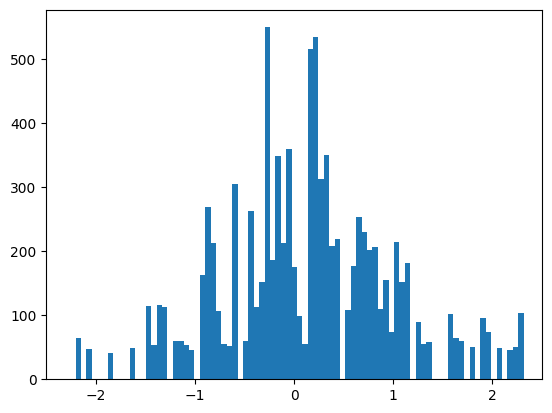

In [19]:
monte = 10000

sample = np.random.choice(degarched, monte, replace=True)
plt.hist(sample, bins=200)
plt.xlim(xmin = -2.5, xmax=2.5)

In [20]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(sample.reshape(-1, 1))
log_dens = kde.score_samples(sample.reshape(-1, 1))
density = np.exp(log_dens)

<Axes: xlabel='x'>

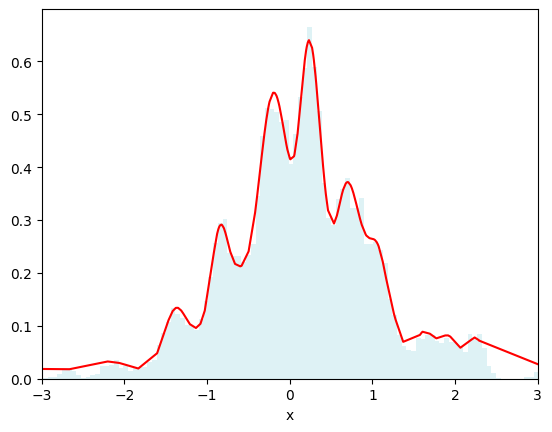

In [21]:
fig, ax = plt.subplots()
ax.set_xlim(-3, 3)
#ax.hist(sample, bins=200, density=True)
semples = kde.sample(20000).T[0]
asd = ax.hist(semples, bins=200, density=True, alpha=0.7, color="#d1edf2")
df = pd.DataFrame(np.array([sample.reshape(-1, 1).T[0], density]).T, columns=['x', 'density']).set_index('x').sort_index()
df['density'].plot(ax=ax, c='r')

In [22]:
sigmas  = pd.read_csv('parameters.csv')['SIGMA']

In [23]:
M       = len(garchvol)
N       = 10000

s0      = btc['Adj.Close'].iloc[0]
k       = s0
strike  = k

T       = 1
dt      = T/M
mu      = 0.3
r       = 0

In [24]:
# # Option pricing via MC
# cp    = np.exp(-mu * m * dt) * np.maximum(St[:,-1]-k,0).mean()
# cp

#Price on Derebit

cp = 1139.85

In [25]:
impliedvol = sigmas

In [26]:
#greeks

def deltafunc(S, K, T, sigma, r):
    d1 = (sp.log(S/K) + (r + 0.5 * sigma**2)*T) / (sigma * sp.sqrt(T))
    return scs.norm.cdf(d1) 

In [27]:
#Hedge 

deltabs         = np.zeros([N,M+1])
ttm             = T - np.arange(1, M+1, 1)/M
mu     = 0.3

# Hedging 
deltabs[:,0]    = deltafunc(s0, strike, T, sigmas.iloc[0], r)

C:\Users\Yassir EL-ORFI\AppData\Local\Temp\ipykernel_14920\3814921228.py:4: DeprecationWarning: scipy.log is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.log instead
  d1 = (sp.log(S/K) + (r + 0.5 * sigma**2)*T) / (sigma * sp.sqrt(T))
C:\Users\Yassir EL-ORFI\AppData\Local\Temp\ipykernel_14920\3814921228.py:4: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  d1 = (sp.log(S/K) + (r + 0.5 * sigma**2)*T) / (sigma * sp.sqrt(T))


In [28]:
# Hedging 


for i in range(1, len(sigmas)):
    deltabs[:,i] = deltafunc(s[:,i], k, T-ttm[i], sigmas.iloc[0], r)

C:\Users\Yassir EL-ORFI\AppData\Local\Temp\ipykernel_14920\3814921228.py:4: DeprecationWarning: scipy.log is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.log instead
  d1 = (sp.log(S/K) + (r + 0.5 * sigma**2)*T) / (sigma * sp.sqrt(T))
C:\Users\Yassir EL-ORFI\AppData\Local\Temp\ipykernel_14920\3814921228.py:4: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  d1 = (sp.log(S/K) + (r + 0.5 * sigma**2)*T) / (sigma * sp.sqrt(T))


ValueError: could not broadcast input array from shape (200,) into shape (10000,)

In [ ]:
cp = np.exp(-r * T) * np.maximum(s[:,-1]-k,0).mean()
cp

NameError: name 's' is not defined

In [ ]:
Pnl = cp

for i in range(1,  len(sigmas)):
    Pnl -= np.exp(r * dt) * ((deltabs[:,i]-deltabs[:,i-1]) * s[:,i])
    
PayoffCheck      = [k if sT < k else 0 for sT in s[:,-1]]
PnL_final        = [Pnl[i] - PayoffCheck[i] for i in range(len(Pnl))]

#delta_final      = [deltabs[i,-1] - 1 if PayoffCheck[i] == k else deltabs[i,-1] for i in range(len(deltabs[:,-1]))]
# PnL_final        = PnL_final + delta_final * s[:,-1]

PnL_final        = PnL_final/cp

NameError: name 's' is not defined

In [ ]:
fig = plt.hist(PnL_final, bins=100, density=True,color='red')
#os.makedirs(os.path.dirname(hedge), exist_ok=True)
plt.savefig('bs_hedge.png', transparent=T)

NameError: name 'PnL_final' is not defined

In [ ]:
bscall  = np.zeros([n,m])
deltabs = np.zeros([n,m])
ttm     = np.linspace(0, T, m+1)

NameError: name 'n' is not defined

In [ ]:
st               = St[:,0]
amount           = cp
delta            = deltabs[:,0]
Pnl              = amount - deltabs[:,0]*st
interest         = np.exp(r* dt)

Pnl

for i in range(len(ttm)):
    t            = T-ttm[i-1]
    Pnl          = interest *Pnl
    newdelta     = deltabs[:,i]
    Pnl          = Pnl - (newdelta-delta)*St[:,i]
    delta        = newdelta
    
Pnl              = Pnl* interest
ST               = St[:,-1]
PayoffCheck      = [k if sT >k  else 0 for sT in ST ]

PnL_final        = [ Pnl[i]+ PayoffCheck[i] for i in range(len(Pnl))]
delta_final      = [deltabs[i,-1] -1 if PayoffCheck[i] == k else deltabs[i,-1] for i in range(len(deltabs[:,-1]))]

PnL_final        = PnL_final + delta_final * ST
PnL_final        = PnL_final/cp  

ValueError: operands could not be broadcast together with shapes (10000,) (10,) 

In [ ]:
c, bins, patches = plt.hist(PnL_final, bins=1000, color='r',alpha=0.7, rwidth=0.7)

plt.xlabel('Relative profit')
plt.ylabel('Frequency')
plt.title('Black Scholes Delta Hedge Relative Profit and Loss ')

maxfreq = c.max()
plt.ylim(ymax = np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
plt.xlim(xmin = -10, xmax = 4)
plt.savefig('PnLBSDeltaHedge1MioInternetk6500',transparent=T)
plt.show()


NameError: name 'PnL_final' is not defined